##### Required libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report,roc_auc_score,roc_curve
from sklearn.ensemble import RandomForestClassifier

##### Importing data

In [3]:
data_for_model=pd.read_csv('E:/DataSkills 2021/Imarticus DSP/Capstone Project/HR Analytics/hr_16_17_for_model.csv',index_col='Employee No')
data_for_testing=pd.read_csv('E:/DataSkills 2021/Imarticus DSP/Capstone Project/HR Analytics/hr_17_18_for_model_testing.csv',index_col='Employee No')
promotion=pd.read_csv('E:/DataSkills 2021/Imarticus DSP/Capstone Project/HR Analytics/promotion.csv',index_col='Employee No')

In [4]:
print(data_for_model.head(2))
print(data_for_testing.head(2))
print(promotion.head(2))

             Employee Position         0         1         2         3  \
Employee No                                                              
1                            2 -0.195717  0.598599  0.213095  1.104051   
2                            2 -0.195717  0.737623 -0.153812  0.509408   

                    4         5         6  Current Status  
Employee No                                                
1           -0.903961 -1.087893  5.202559               0  
2            0.881900 -1.273269  5.701115               0  
             Employee Position         0         1         2         3  \
Employee No                                                              
1                            1 -0.241378  0.762908  0.015799 -0.039001   
2                            2 -0.241378  0.768915  0.137515 -0.849394   

                    4         5         6  Current Status  
Employee No                                                
1           -0.807247 -1.501321  5.698573     

In [21]:
promotion['promotion'].value_counts()

0    489
1    162
Name: promotion, dtype: int64

### Model Building

##### SMOTE  - Synthetic Minority Oversampling Technique

##### train data

In [5]:
sm = SMOTE(random_state=19)
X_train, y_train = sm.fit_resample(data_for_model.drop('Current Status',axis=1),data_for_model['Current Status'])

y_train.value_counts(normalize=True)

1    0.5
0    0.5
Name: Current Status, dtype: float64

##### test data

In [6]:
X_test = data_for_testing.drop('Current Status',axis=1)

y_test = data_for_testing['Current Status']

##### Logistic Regression

In [7]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

hr_predict=clf.predict(X_test)
hr_predict_df=pd.DataFrame({'Test Data':y_test,'Prediction':hr_predict}) 
# hr_predict_df.rename(columns={'index':'Employee No'},inplace=True)

cm=confusion_matrix(y_test, hr_predict)
print(cm)

#print({'tn':cm[0,0],'fp':cm[0,1],'fn':cm[1,0],'tp':cm[1,1]})

''' {'tn': 483, 'fp': 4, 'fn': 3, 'tp': 92} '''

#hr_predict_df.loc[~(hr_predict_df['Test Data']==hr_predict_df['Prediction'])]

print(classification_report(y_test,hr_predict))

[[666 162]
 [ 27 118]]
              precision    recall  f1-score   support

           0       0.96      0.80      0.88       828
           1       0.42      0.81      0.56       145

    accuracy                           0.81       973
   macro avg       0.69      0.81      0.72       973
weighted avg       0.88      0.81      0.83       973



Logistic Regression ROC AUC = 0.858


Text(0, 0.5, 'True Positive Rate')

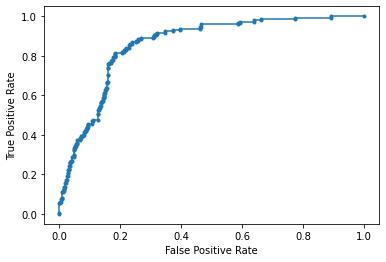

In [9]:
# ROC-AUC curve analysis
clf_probs = clf.predict_proba(X_test)[:,1]

#hr_predict_df['Test'].replace({'Active':0,'Resigned':1},inplace=True)
#hr_predict_df['Prediction'].replace({'Active':0,'Resigned':1},inplace=True)

print('Logistic Regression ROC AUC = %.3f' % roc_auc_score(hr_predict_df['Test Data'], clf_probs))

fpr, tpr, thresholds = roc_curve(hr_predict_df['Test Data'], clf_probs)

plt.plot(fpr,tpr,marker='.',label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

##### K-Nearest Neighbor (KNN)

Text(0, 0.5, 'Mean Error')

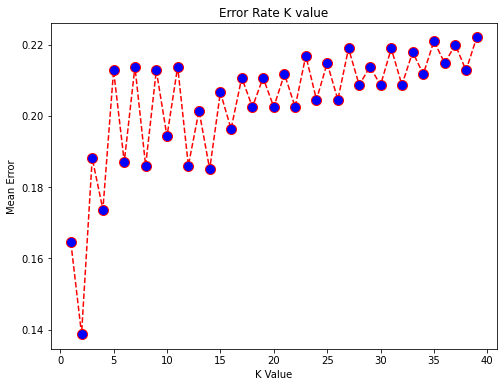

In [10]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
# elbow methos
error=[]
for i in range(1,40):
    knn=KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i=knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

plt.figure(figsize=(8,6))
plt.plot(range(1,40),error,color='red',linestyle='dashed',marker='o',
         markerfacecolor='blue',markersize=10)
plt.title('Error Rate K value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

##### KNN is not the correct algorithm for this problem

##### Random Forest

In [11]:
clf_rf = RandomForestClassifier(max_depth=12,random_state=0)
clf_rf.fit(X_train,y_train)

hr_predict_rf = clf_rf.predict(X_test)
hr_predict_rf_df=pd.DataFrame({'Test Data':y_test,'Prediction':hr_predict_rf}) #.reset_index()
# hr_predict_rf_df.rename(columns={'index':'Employee No'},inplace=True)

cm_rf=confusion_matrix(y_test, hr_predict_rf)
print(cm_rf)

print({'tn':cm_rf[0,0],'fp':cm_rf[0,1],'fn':cm_rf[1,0],'tp':cm_rf[1,1]})

#hr_predict_rf_df.loc[~(hr_predict_rf_df['Test Data']==hr_predict_rf_df['Prediction'])]

print(classification_report(y_test,hr_predict_rf))

[[771  57]
 [ 32 113]]
{'tn': 771, 'fp': 57, 'fn': 32, 'tp': 113}
              precision    recall  f1-score   support

           0       0.96      0.93      0.95       828
           1       0.66      0.78      0.72       145

    accuracy                           0.91       973
   macro avg       0.81      0.86      0.83       973
weighted avg       0.92      0.91      0.91       973



#### Random Forest Classifier is performing better than the Logistic Regression
We will do GridsearchCV done to find the best hyper-parametric values. We will check if inputting the optimum parameter values in the Random Forest model would improve  the accuracy along with the other indicators of the model.

In [12]:
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth' : [8,10,12,15,20],
             'n_estimators': [200, 500]}

gridF = GridSearchCV(estimator=clf_rf, param_grid=param_grid, cv = 3, verbose = 1)
bestF = gridF.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [13]:
gridF.best_params_

{'max_depth': 8, 'n_estimators': 200}

In [39]:
clf_rf = RandomForestClassifier(max_depth=12,n_estimators= 200,random_state=0)
clf_rf.fit(X_train,y_train)

hr_predict_rf = clf_rf.predict(X_test)
hr_predict_rf_df=pd.DataFrame({'Test Data':y_test,'Prediction':hr_predict_rf}) #.reset_index()
# hr_predict_rf_df.rename(columns={'index':'Employee No'},inplace=True)

cm_rf=confusion_matrix(y_test, hr_predict_rf)
print(cm_rf)

print({'tn':cm_rf[0,0],'fp':cm_rf[0,1],'fn':cm_rf[1,0],'tp':cm_rf[1,1]})

#hr_predict_rf_df.loc[~(hr_predict_rf_df['Test Data']==hr_predict_rf_df['Prediction'])]

print(classification_report(y_test,hr_predict_rf))

[[772  56]
 [ 30 115]]
{'tn': 772, 'fp': 56, 'fn': 30, 'tp': 115}
              precision    recall  f1-score   support

           0       0.96      0.93      0.95       828
           1       0.67      0.79      0.73       145

    accuracy                           0.91       973
   macro avg       0.82      0.86      0.84       973
weighted avg       0.92      0.91      0.91       973



Random Forests ROC AUC = 0.928


Text(0, 0.5, 'True Positive Rate')

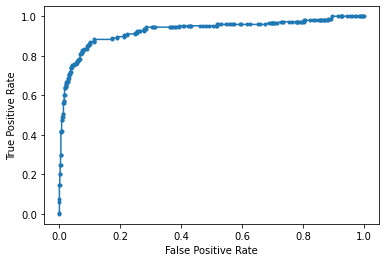

In [40]:
# ROC-AUC curve analysis
clf_rf_probs = clf_rf.predict_proba(X_test)[:,1]

#hr_predict_df['Test'].replace({'Active':0,'Resigned':1},inplace=True)
#hr_predict_df['Prediction'].replace({'Active':0,'Resigned':1},inplace=True)

print('Random Forests ROC AUC = %.3f' % roc_auc_score(hr_predict_rf_df['Test Data'], clf_rf_probs))

fpr, tpr, thresholds = roc_curve(hr_predict_rf_df['Test Data'], clf_rf_probs)

plt.plot(fpr,tpr,marker='.',label='Random Forests')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [41]:
promoted = promotion.loc[promotion['promotion'] == 1][['promotion']]
promoted_attrition = promoted.join(hr_predict_rf_df['Prediction'],how='left')
promoted_attrition['Prediction'].value_counts()

0    160
1      2
Name: Prediction, dtype: int64

In [38]:
#hr_predict_rf_df.loc[(hr_predict_rf_df['Test Data']== 1) & (hr_predict_rf_df['Prediction'] == 1)]

In [42]:
promoted_attrition.to_csv('E:/DataSkills 2021/Imarticus DSP/Capstone Project/HR Analytics/promoted_attrition.csv')